## Importing the Data

In [1]:
# Constants
DATASET_DIR = './data/'
GLOVE_DIR = './glove.6B/'
SAVE_DIR = './'

import os
import pandas as pd

X = pd.read_csv(os.path.join(DATASET_DIR, 'training_set_rel3.tsv'), sep='\t', encoding='ISO-8859-1')
y = X['domain1_score']
X = X.dropna(axis=1)
# X = X.drop(columns=['rater1_domain1', 'rater2_domain1'])

In [2]:
X = X.drop(['rater1_domain1', 'rater2_domain1'], axis=1)

In [3]:
X.head()

,essay_id,essay_set,essay,domain1_score
0,1,1,"Dear local newspaper, I think effects computer...",8
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",9
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",7
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",10
4,5,1,"Dear @LOCATION1, I know having computers has a...",8


In [4]:
from matplotlib import pyplot as plt
%matplotlib inline

In [5]:
len(X.index)

12976

In [6]:
# number of essays in each essay set
X.groupby(by='essay_set').count().drop(['essay', 'domain1_score'], axis=1)

,essay_id
essay_set,
1,1783
2,1800
3,1726
4,1770
5,1805
6,1800
7,1569
8,723


In [7]:
X[X['essay_set'] == 8].iloc[0]

essay_id                                                     20716
essay_set                                                        8
essay             A long time ago when I was in third grade I h...
domain1_score                                                   34
Name: 12253, dtype: object

Minimum and Maximum Scores for each essay set.

essay_set
1    AxesSubplot(0.125,0.125;0.775x0.755)
2    AxesSubplot(0.125,0.125;0.775x0.755)
3    AxesSubplot(0.125,0.125;0.775x0.755)
4    AxesSubplot(0.125,0.125;0.775x0.755)
5    AxesSubplot(0.125,0.125;0.775x0.755)
6    AxesSubplot(0.125,0.125;0.775x0.755)
7    AxesSubplot(0.125,0.125;0.775x0.755)
8    AxesSubplot(0.125,0.125;0.775x0.755)
Name: domain1_score, dtype: object

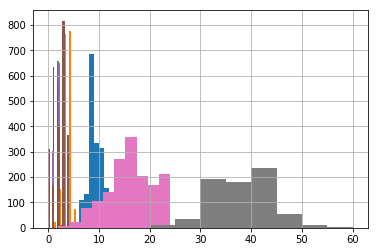

In [8]:
X.groupby(by='essay_set')['domain1_score'].hist()

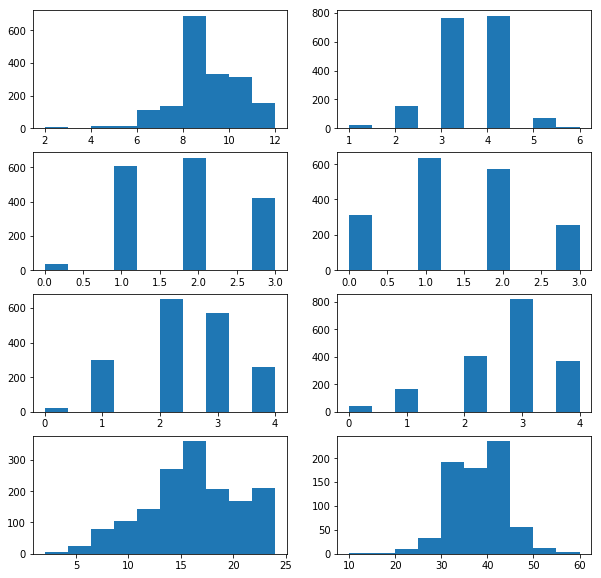

In [9]:
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(10,10))

for i in range(1, 9):
    ax[(i-1)//2][(i-1)%2].hist(X[X['essay_set'] == i]['domain1_score'])

In [10]:
minimum_scores = [-1, 2, 1, 0, 0, 0, 0, 0, 0]
maximum_scores = [-1, 12, 6, 3, 3, 4, 4, 30, 60]

## Preprocessing the Data

We will preprocess all essays and convert them to feature vectors so that they can be fed into the RNN.

These are all helper functions used to clean the essays.

In [11]:
import numpy as np
import nltk
import re
from nltk.corpus import stopwords
from gensim.models import Word2Vec

def essay_to_wordlist(essay_v, remove_stopwords):
    """Remove the tagged labels and word tokenize the sentence."""
    essay_v = re.sub("[^a-zA-Z]", " ", essay_v)
    words = essay_v.lower().split()
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
    return (words)

def essay_to_sentences(essay_v, remove_stopwords):
    """Sentence tokenize the essay and call essay_to_wordlist() for word tokenization."""
    tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
    raw_sentences = tokenizer.tokenize(essay_v.strip())
    sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            sentences.append(essay_to_wordlist(raw_sentence, remove_stopwords))
    return sentences

def makeFeatureVec(words, model, num_features):
    """Make Feature Vector from the words list of an Essay."""
    featureVec = np.zeros((num_features,),dtype="float32")
    num_words = 0.
    index2word_set = set(model.wv.index2word)
    for word in words:
        if word in index2word_set:
            num_words += 1
            featureVec = np.add(featureVec,model[word])        
    featureVec = np.divide(featureVec,num_words)
    return featureVec

def getAvgFeatureVecs(essays, model, num_features):
    """Main function to generate the word vectors for word2vec model."""
    counter = 0
    essayFeatureVecs = np.zeros((len(essays),num_features),dtype="float32")
    for essay in essays:
        essayFeatureVecs[counter] = makeFeatureVec(essay, model, num_features)
        counter = counter + 1
    return essayFeatureVecs

/home/skripniuk/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Defining the model 

Here we define a 2-Layer LSTM Model. 

Note that instead of using sigmoid activation in the output layer we will use
Relu since we are not normalising training labels.

In [12]:
from keras.layers import Embedding, LSTM, Dense, Dropout, Lambda, Flatten
from keras.models import Sequential, load_model, model_from_config
import keras.backend as K

def get_model():
    """Define the model."""
    model = Sequential()
    model.add(LSTM(300, dropout=0.4, recurrent_dropout=0.4, input_shape=[1, 300], return_sequences=True))
    model.add(LSTM(64, recurrent_dropout=0.4))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='relu'))

    model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mae'])
    model.summary()

    return model

In [13]:
model = get_model()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1, 300)            721200    
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                93440     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 814,705
Trainable params: 814,705
Non-trainable params: 0
_________________________________________________________________


In [14]:
from keras.models import load_model


In [15]:
lstm_model = load_model('model_weights/final_lstm.h5')

In [16]:
lstm_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 1, 300)            721200    
_________________________________________________________________
lstm_12 (LSTM)               (None, 64)                93440     
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 814,705
Trainable params: 814,705
Non-trainable params: 0
_________________________________________________________________


## Training Phase

Now we train the model on the dataset.

We will use 5-Fold Cross Validation and measure the Quadratic Weighted Kappa for each fold.
We will then calculate Average Kappa for all the folds.

In [17]:
from gensim.models import KeyedVectors

In [18]:
wv_from_bin = KeyedVectors.load_word2vec_format("word2vecmodel.bin", binary=True)

In [19]:
test_essays = X['essay']

In [20]:
num_features = 300 
min_word_count = 40
num_workers = 4
context = 10
downsampling = 1e-3

In [21]:
clean_test_essays = []
for essay_v in test_essays:
    clean_test_essays.append(essay_to_wordlist( essay_v, remove_stopwords=True ))
testDataVecs = getAvgFeatureVecs( clean_test_essays, wv_from_bin, num_features )

In [22]:
testDataVecs = np.array(testDataVecs)
# Reshaping train and test vectors to 3 dimensions. (1 represnts one timestep)
testDataVecs = np.reshape(testDataVecs, (testDataVecs.shape[0], 1, testDataVecs.shape[1]))

In [23]:
y_test = X['domain1_score']

In [24]:
from sklearn.metrics import cohen_kappa_score

In [25]:
y_pred = lstm_model.predict(testDataVecs)
    
# Round y_pred to the nearest integer.
y_pred = np.around(y_pred)

# Evaluate the model on the evaluation metric. "Quadratic mean averaged Kappa"
result = cohen_kappa_score(y_test.values,y_pred,weights='quadratic')
print("Kappa Score: {}".format(result))


Kappa Score: 0.9627824918083597


(array([8500.,  815., 1533.,  509.,  632.,  229.,   98.,  106.,  203.,
         351.]),
 array([ 0.,  4.,  8., 12., 16., 20., 24., 28., 32., 36., 40.]),
 <a list of 10 Patch objects>)

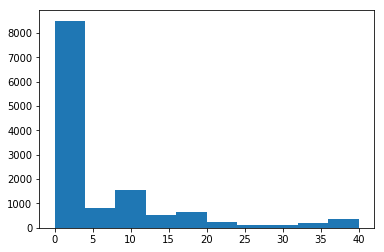

In [26]:
plt.hist(y_pred)

(array([ 625., 4009., 3677.,  333.,  164.]),
 array([1, 2, 3, 4, 5, 6]),
 <a list of 5 Patch objects>)

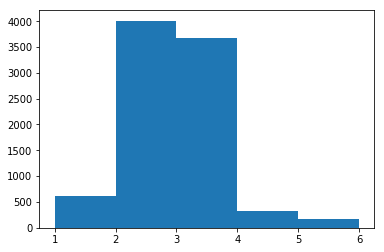

In [27]:
plt.hist(y_pred, range(1,7))

(array([110., 318., 652., 576., 226.,  79.,  80.,  99., 140., 190., 204.,
        177., 149., 102.,  84.,  64.,  46.,  35.,  31.,  24.,  24.,  19.,
         25.,  33.,  17.,  31.,  45.,  34.,  44.,  80.,  92., 102.,  93.,
         55.,   9.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
 array([ 6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
        23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,
        40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56,
        57, 58, 59]),
 <a list of 53 Patch objects>)

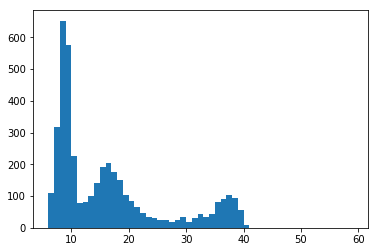

In [28]:
plt.hist(y_pred, range(6,60))

In [29]:
for i in range(1,9):
    print("Kappa Score: essay set {0}: {1}".format(i, cohen_kappa_score(y_test[X['essay_set']==i].values,y_pred[X['essay_set']==i],weights='quadratic')))

Kappa Score: essay set 1: 0.418003585079612
Kappa Score: essay set 2: 0.06478513760444593
Kappa Score: essay set 3: 0.11166796873466467
Kappa Score: essay set 4: 0.20321438676152948
Kappa Score: essay set 5: 0.2839883407487712
Kappa Score: essay set 6: 0.31989011408294865
Kappa Score: essay set 7: 0.6160905753003008
Kappa Score: essay set 8: 0.3826673365953013


In [ ]:
0.4119648928977989,
 0.02591404408055986,
 0.10877239100229052,
 0.14880894311275894,
 0.24700573449809748,
 0.3031976418790343,
 0.615828592182176,
 0.38799451654242445]

In [117]:
!ls

 data		 mysite      ScreenShots
 models		 README.md  'Training LSTM Model.ipynb'
 model_weights	 score	     word2vecmodel.bin


In [30]:
from score.score import quadratic_weighted_kappa, linear_weighted_kappa, kappa, mean_quadratic_weighted_kappa

In [134]:
from importlib import reload

In [54]:
from functools import reduce
import numpy

def confusion_matrix(rater_a, rater_b,
         min_rating=None, max_rating=None):
    """
    Returns the confusion matrix between rater's ratings
    """
    assert(len(rater_a)==len(rater_b))
    if min_rating is None:
        min_rating = min(reduce(min, rater_a), reduce(min, rater_b))
    if max_rating is None:
        max_rating = max(reduce(max, rater_a), reduce(max, rater_b))
    num_ratings = int(max_rating - min_rating + 1)
    conf_mat = [[0 for i in range(num_ratings)]
                for j in range(num_ratings)]
    for a,b in zip(rater_a,rater_b):
        conf_mat[a-min_rating][b-min_rating] += 1
    return conf_mat

def histogram(ratings, min_rating=None, max_rating=None):
    """
    Returns the counts of each type of rating that a rater made
    """
    if min_rating is None: min_rating = reduce(min, ratings)
    if max_rating is None: max_rating = reduce(max, ratings)
    num_ratings = max_rating - min_rating + 1
    hist_ratings = [0 for x in range(num_ratings)]
    for r in ratings:
        hist_ratings[r-min_rating] += 1
    return hist_ratings

def quadratic_weighted_kappa(rater_a, rater_b,
                             min_rating = None, max_rating = None):
    """
    Calculates the quadratic weighted kappa
    scoreQuadraticWeightedKappa calculates the quadratic weighted kappa
    value, which is a measure of inter-rater agreement between two raters
    that provide discrete numeric ratings.  Potential values range from -1  
    (representing complete disagreement) to 1 (representing complete
    agreement).  A kappa value of 0 is expected if all agreement is due to
    chance.
    
    scoreQuadraticWeightedKappa(rater_a, rater_b), where rater_a and rater_b
    each correspond to a list of integer ratings.  These lists must have the
    same length.
    
    The ratings should be integers, and it is assumed that they contain
    the complete range of possible ratings.
   
    score_quadratic_weighted_kappa(X, min_rating, max_rating), where min_rating
    is the minimum possible rating, and max_rating is the maximum possible
    rating
    """
    rater_a = numpy.array(rater_a).reshape((-1,))
    rater_b = numpy.array(rater_b).reshape((-1,))
    
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(reduce(min, rater_a), reduce(min, rater_b))
    if max_rating is None:
        max_rating = max(reduce(max, rater_a), reduce(max, rater_b))
    
    conf_mat = confusion_matrix(rater_a, rater_b,
                     min_rating, max_rating)
    num_ratings = len(conf_mat)
    num_scored_items = float(len(rater_a))

    hist_rater_a = histogram(rater_a, min_rating, max_rating)
    hist_rater_b = histogram(rater_b, min_rating, max_rating)

    numerator = 0.0
    denominator = 0.0

    for i in range(num_ratings):
        for j in range(num_ratings):
            expected_count = (hist_rater_a[i]*hist_rater_b[j]
                      / num_scored_items) 
            d = pow(i-j,2.0) / pow(num_ratings-1, 2.0)
            numerator += d*conf_mat[i][j] / num_scored_items
            denominator += d*expected_count / num_scored_items

    return 1.0 - numerator / denominator

def mean_quadratic_weighted_kappa(kappas, weights=None):
    """
    Calculates the mean of the quadratic
    weighted kappas after applying Fisher's r-to-z transform, which is
    approximately a variance-stabilizing transformation.  This
    transformation is undefined if one of the kappas is 1.0, so all kappa
    values are capped in the range (-0.999, 0.999).  The reverse
    transformation is then applied before returning the result.
    
    mean_quadratic_weighted_kappa(kappas), where kappas is a vector of
    kappa values

    mean_quadratic_weighted_kappa(kappas, weights), where weights is a vector
    of weights that is the same size as kappas.  Weights are applied in the
    z-space
    """
    kappas = numpy.array(kappas, dtype=float)
    if weights is None:
        weights = numpy.ones(numpy.shape(kappas))
    else:
        weights = weights / numpy.mean(weights)

    # ensure that kappas are in the range [-.999, .999]
    kappas = numpy.array([min(x, .999) for x in kappas])
    kappas = numpy.array([max(x, -.999) for x in kappas])
    
    z = 0.5 * numpy.log( (1+kappas)/(1-kappas) ) * weights
    z = numpy.mean(z)
    kappa = (numpy.exp(2*z)-1) / (numpy.exp(2*z)+1)
    return kappa


In [41]:
from score import score

In [136]:
reload(quadratic_weighted_kappa)

TypeError: reload() argument must be a module

In [131]:
from functools import reduce

In [48]:
y_test[X['essay_set']==i].values.astype(int).shape

(723,)

In [50]:
y_pred[X['essay_set']==i].astype(int).shape

(723, 1)

In [55]:
kappas = [quadratic_weighted_kappa(
    y_test[X['essay_set']==i].values.astype(int),y_pred[X['essay_set']==i].astype(int))
          for i in range(1, 9)]
kappas

[0.4119648928977989,
 0.02591404408055986,
 0.10877239100229052,
 0.14880894311275894,
 0.24700573449809748,
 0.3031976418790343,
 0.615828592182176,
 0.38799451654242445]

In [56]:
mean_quadratic_weighted_kappa(kappas)

0.2931389333073196

In [7]:
from sklearn.cross_validation import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import cohen_kappa_score

cv = KFold(len(X), n_folds=5, shuffle=True)
results = []
y_pred_list = []

count = 1
for traincv, testcv in cv:
    print("\n--------Fold {}--------\n".format(count))
    X_test, X_train, y_test, y_train = X.iloc[testcv], X.iloc[traincv], y.iloc[testcv], y.iloc[traincv]
    
    train_essays = X_train['essay']
    test_essays = X_test['essay']
    
    sentences = []
    
    for essay in train_essays:
            # Obtaining all sentences from the training essays.
            sentences += essay_to_sentences(essay, remove_stopwords = True)
            
    # Initializing variables for word2vec model.
    num_features = 300 
    min_word_count = 40
    num_workers = 4
    context = 10
    downsampling = 1e-3

    print("Training Word2Vec Model...")
    model = Word2Vec(sentences, workers=num_workers, size=num_features, min_count = min_word_count, window = context, sample = downsampling)

    model.init_sims(replace=True)
    model.wv.save_word2vec_format('word2vecmodel.bin', binary=True)

    clean_train_essays = []
    
    # Generate training and testing data word vectors.
    for essay_v in train_essays:
        clean_train_essays.append(essay_to_wordlist(essay_v, remove_stopwords=True))
    trainDataVecs = getAvgFeatureVecs(clean_train_essays, model, num_features)
    
    clean_test_essays = []
    for essay_v in test_essays:
        clean_test_essays.append(essay_to_wordlist( essay_v, remove_stopwords=True ))
    testDataVecs = getAvgFeatureVecs( clean_test_essays, model, num_features )
    
    trainDataVecs = np.array(trainDataVecs)
    testDataVecs = np.array(testDataVecs)
    # Reshaping train and test vectors to 3 dimensions. (1 represnts one timestep)
    trainDataVecs = np.reshape(trainDataVecs, (trainDataVecs.shape[0], 1, trainDataVecs.shape[1]))
    testDataVecs = np.reshape(testDataVecs, (testDataVecs.shape[0], 1, testDataVecs.shape[1]))
    
    lstm_model = get_model()
    lstm_model.fit(trainDataVecs, y_train, batch_size=64, epochs=50)
    #lstm_model.load_weights('./model_weights/final_lstm.h5')
    y_pred = lstm_model.predict(testDataVecs)
    
    # Save any one of the 8 models.
    if count == 5:
         lstm_model.save('./model_weights/final_lstm.h5')
    
    # Round y_pred to the nearest integer.
    y_pred = np.around(y_pred)
    
    # Evaluate the model on the evaluation metric. "Quadratic mean averaged Kappa"
    result = cohen_kappa_score(y_test.values,y_pred,weights='quadratic')
    print("Kappa Score: {}".format(result))
    results.append(result)

    count += 1
        


--------Fold 1--------

Training Word2Vec Model...


/Users/ronitmankad/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 1, 300)            721200    
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                93440     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 814,705
Trainable params: 814,705
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
10380/10380 [==============================] - 6s 601us/step - loss: 63.5235 - mean_absolute_error: 4.3085
Epoch 2/50
10380/10380 [==============================] - 4s 402us/step - loss: 38.5016 - mean_absolute_error: 3.4547
Epoch 3/50
10380/10380 [========

10381/10381 [==============================] - 4s 432us/step - loss: 13.7165 - mean_absolute_error: 2.1590
Epoch 16/50
10381/10381 [==============================] - 6s 547us/step - loss: 13.3761 - mean_absolute_error: 2.0890
Epoch 17/50
10381/10381 [==============================] - 5s 484us/step - loss: 12.6187 - mean_absolute_error: 2.0184
Epoch 18/50
10381/10381 [==============================] - 5s 469us/step - loss: 12.5590 - mean_absolute_error: 2.0113
Epoch 19/50
10381/10381 [==============================] - 5s 468us/step - loss: 11.9494 - mean_absolute_error: 1.9737
Epoch 20/50
10381/10381 [==============================] - 5s 454us/step - loss: 11.9072 - mean_absolute_error: 1.9554
Epoch 21/50
10381/10381 [==============================] - 4s 419us/step - loss: 11.8927 - mean_absolute_error: 1.9263
Epoch 22/50
10381/10381 [==============================] - 5s 448us/step - loss: 11.4953 - mean_absolute_error: 1.8964
Epoch 23/50
10381/10381 [==============================] - 5

10381/10381 [==============================] - 5s 482us/step - loss: 9.1404 - mean_absolute_error: 1.6770 2s - lo
Epoch 38/50
10381/10381 [==============================] - 5s 482us/step - loss: 9.1458 - mean_absolute_error: 1.6917
Epoch 39/50
10381/10381 [==============================] - 5s 477us/step - loss: 8.8663 - mean_absolute_error: 1.6622
Epoch 40/50
10381/10381 [==============================] - 4s 429us/step - loss: 9.2812 - mean_absolute_error: 1.6708
Epoch 41/50
10381/10381 [==============================] - 4s 427us/step - loss: 8.7367 - mean_absolute_error: 1.6541
Epoch 42/50
10381/10381 [==============================] - 4s 423us/step - loss: 9.1140 - mean_absolute_error: 1.6701
Epoch 43/50
10381/10381 [==============================] - 6s 577us/step - loss: 8.7978 - mean_absolute_error: 1.6674
Epoch 44/50
10381/10381 [==============================] - 5s 481us/step - loss: 8.5478 - mean_absolute_error: 1.6401
Epoch 45/50
10381/10381 [==============================] - 5

The Avg. Kappa Score is 0.961 which is the highest we have ever seen on this dataset.

In [10]:
print("Average Kappa score after a 5-fold cross validation: ",np.around(np.array(results).mean(),decimals=4))

Average Kappa score after a 5-fold cross validation:  0.9613
